In [2]:
import os
import torch
import torch.utils.data
import torchvision
from pycocotools.coco import COCO
from torchsummary import summary
import numpy as np
import torchvision.transforms as T


import torchfunc

from PIL import Image
import requests
import matplotlib.pyplot as plt

import cv2

%config InlineBackend.figure_format = 'retina'


In [3]:
# torch.set_default_dtype(torch.half)

In [4]:
class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [5]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
# path to your own data and coco file
train_data_dir = 'data/coco_mini/trainset'
train_coco = 'data/coco_mini/instances_minitrain2017.json'

# create own Dataset
my_dataset = myOwnDataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform()
                          )

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 1

# own DataLoader
data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          collate_fn=collate_fn)


loading annotations into memory...
Done (t=2.35s)
creating index...
index created!


In [19]:
imgs, classes = next(iter(data_loader))

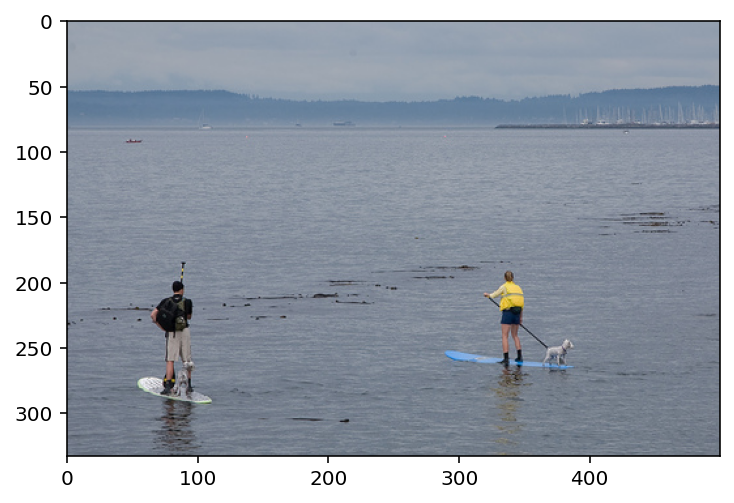

In [23]:
plt.imshow(np.transpose(imgs[0].numpy(), (1,2,0)))

In [24]:
classes[0]

{'boxes': tensor([[364.0900, 242.9700, 388.4700, 264.5600],
         [318.0300, 189.2000, 349.4600, 262.5300],
         [ 62.9900, 198.8900,  96.9700, 287.0300],
         [288.6600, 252.1200, 389.3200, 265.6300],
         [ 53.6500, 271.6800, 112.1000, 292.3100],
         [392.2900,  75.4100, 402.3700,  79.2700],
         [425.9600,  83.4900, 430.4500,  86.8400],
         [ 44.1500,  89.9400,  57.7100,  93.2200],
         [404.9500,  76.1900, 415.2200,  78.8800],
         [446.3500,  76.5400, 455.8900,  80.2600],
         [474.4500,  61.4600, 490.5900,  81.3700],
         [495.9800,  74.7700, 500.0000,  79.4100],
         [ 67.9000, 210.9300,  92.3400, 238.0600],
         [464.6800,  61.4300, 474.1300,  81.6800],
         [174.7900,  77.2000, 178.9000,  79.7700],
         [339.0800, 219.4200, 347.8600, 224.2700],
         [417.2900,  65.0900, 429.5600,  81.3700],
         [ 97.0000,  61.0000, 220.0000,  85.0000]]),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

# Testing pretrained model, drawing bb

In [8]:
coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))
transform = T.Compose([
    T.ToTensor(),
])

In [9]:
def predict(image, model, device, detection_threshold):
    # transform the image to tensor
    image = transform(image).to(device)

    image = image.unsqueeze(0) # add a batch dimension
    with torch.no_grad():
        outputs = model(image) # get the predictions on the image

    # get all the scores
    scores = list(outputs[0]['scores'].detach().cpu().numpy())
    # index of those scores which are above a certain threshold
    thresholded_preds_inidices = [scores.index(i) for i in scores if i > detection_threshold]

    # get all the predicted bounding boxes
    bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # get boxes above the threshold score
    boxes = bboxes[np.array(scores) >= detection_threshold].astype(np.int32)

    # get all the predicited class names
    labels = outputs[0]['labels'].cpu().numpy()
    pred_classes = [coco_names[labels[i]] for i in thresholded_preds_inidices]
    return boxes, pred_classes

In [10]:
def draw_boxes(boxes, classes, image):
    for i, box in enumerate(boxes):
        color = COLORS[coco_names.index(classes[i])]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image

In [16]:
# download or load the model from disk
model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True, 
                                                            min_size=800)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load the model onto the computation device
model.eval().to(device);

In [12]:
image = Image.open("/home/daniel/Documents/notebooks/object-detection/data/coco_mini/trainset/000000000030.jpg").convert('RGB')
# a NumPy copy for OpenCV functions
image_array = np.array(image)
# convert to OpenCV BGR color format
image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)

In [13]:
# get the bounding boxes and class labels
boxes, classes = predict(image, model, device, 0.6)
# get the final image
result = draw_boxes(boxes, classes, image_array)

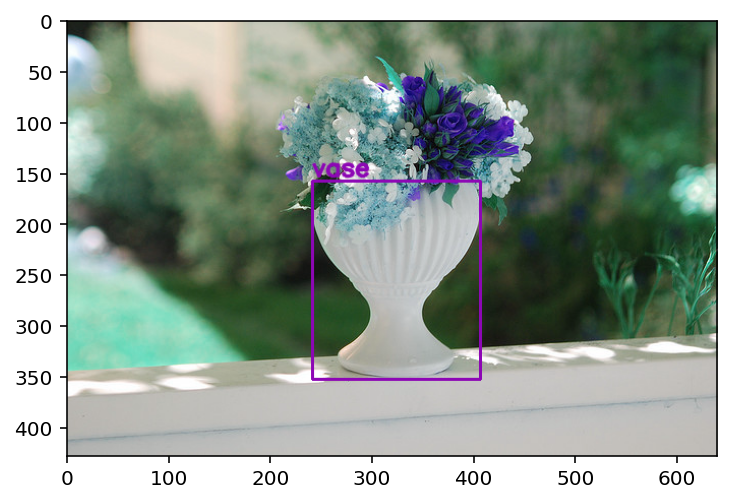

In [15]:
plt.imshow(result)
plt.show()

# Training model

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [ ]:

num_classes = 91
num_epochs = 2
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)


In [ ]:
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')